## Error Analysis

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import joblib
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 0) 
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

## Part 1: Global Performance Overview

In [65]:
lr_tf = pd.read_csv("/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/lr_tf_val_predictions.csv")
svm = pd.read_csv("/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/svm_val_predictions.csv")

In [66]:
load_path = "/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/lr_best_model.pkl"
lr_tf_model = joblib.load(load_path)

### Confusion Matrices

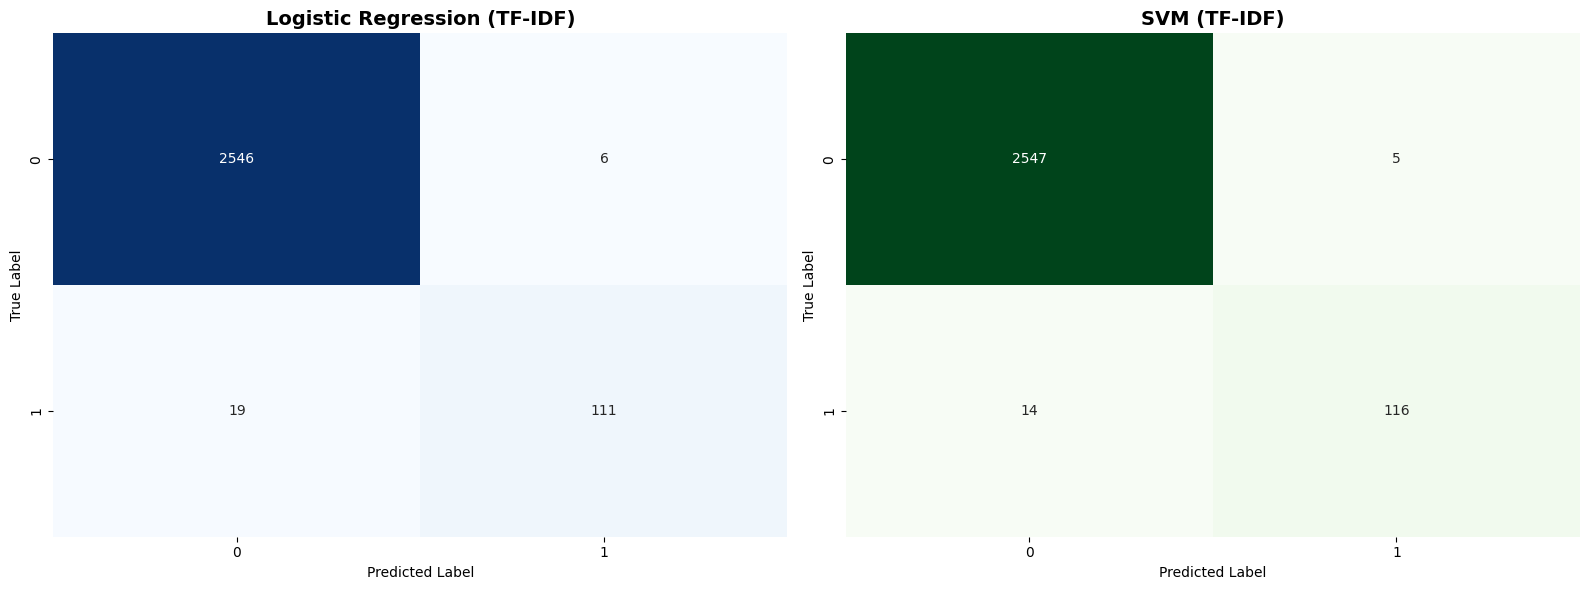

In [67]:
# 1. confusion matrix
cm_lr  = confusion_matrix(lr_tf['true_label'], lr_tf['predicted_label'])
cm_svm = confusion_matrix(svm['true_label'], svm['predicted_label'])

# 2. plot confusion matrix side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Logistic Regression ---
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Logistic Regression (TF-IDF)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# --- Plot 2: SVM ---
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False) # 我换了个绿色区分一下
axes[1].set_title('SVM (TF-IDF)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


### Threshold Impact

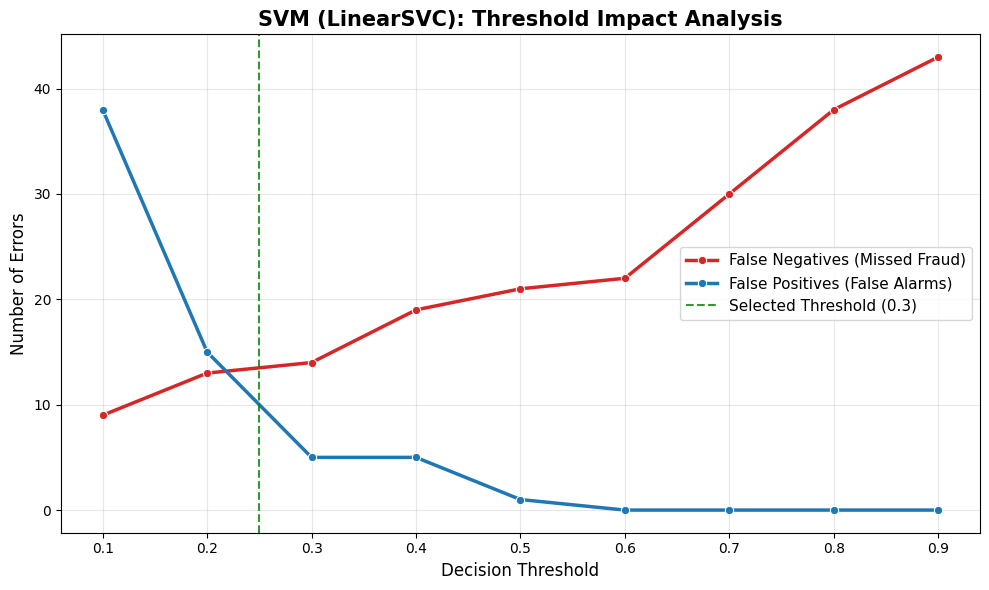

   Threshold  False Negatives  False Positives    Recall
0        0.1                9               38  0.930769
1        0.2               13               15  0.900000
2        0.3               14                5  0.892308
3        0.4               19                5  0.853846
4        0.5               21                1  0.838462
5        0.6               22                0  0.830769
6        0.7               30                0  0.769231
7        0.8               38                0  0.707692
8        0.9               43                0  0.669231


In [68]:
def plot_threshold_impact(df, model_name):
    """
    Analyzes and plots the trade-off between False Negatives and False Positives 
    across different decision thresholds.
    """
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    results = []

    for t in thresholds:
        # Generate predictions based on the current threshold
        pred = (df['fraud_probability'] >= t).astype(int)
        
        # Calculate Confusion Matrix elements
        tn, fp, fn, tp = confusion_matrix(df['true_label'], pred).ravel()
        
        # Calculate Recall (Sensitivity) for context
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        results.append({
            'Threshold': t,
            'False Negatives': fn,      # Missed Fraud (Critical Risk)
            'False Positives': fp,      # False Alarms (User Friction)
            'Recall': recall
        })

    # Convert results to a DataFrame for easy plotting
    impact_df = pd.DataFrame(results)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    
    # Plot Line 1: False Negatives (The "Missed Fraud" Risk) - usually Red
    sns.lineplot(
        data=impact_df, 
        x='Threshold', 
        y='False Negatives', 
        marker='o', 
        label='False Negatives (Missed Fraud)', 
        color='#d62728', # Red
        linewidth=2.5
    )
    
    # Plot Line 2: False Positives (The "False Alarm" Cost) - usually Blue
    sns.lineplot(
        data=impact_df, 
        x='Threshold', 
        y='False Positives', 
        marker='o', 
        label='False Positives (False Alarms)', 
        color='#1f77b4', # Blue
        linewidth=2.5
    )
    
    # Highlight the chosen optimal threshold 
    plt.axvline(x=0.25, color='green', linestyle='--', alpha=0.8, label='Selected Threshold (0.3)')
    
    # Formatting the plot
    plt.title(f'{model_name}: Threshold Impact Analysis', fontsize=15, fontweight='bold')
    plt.xlabel('Decision Threshold', fontsize=12)
    plt.ylabel('Number of Errors', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()
    
    return impact_df

impact_table = plot_threshold_impact(svm, "SVM (LinearSVC)")
print(impact_table)

## Part 2: Logistic Regression with TF-IDF features

### 1. Top Features


/var/folders/qb/7v1154wn6wd9cjd9z10hm0d00000gn/T/ipykernel_53970/1452477606.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_positive, y='feature', x='coef', palette='Reds_r')


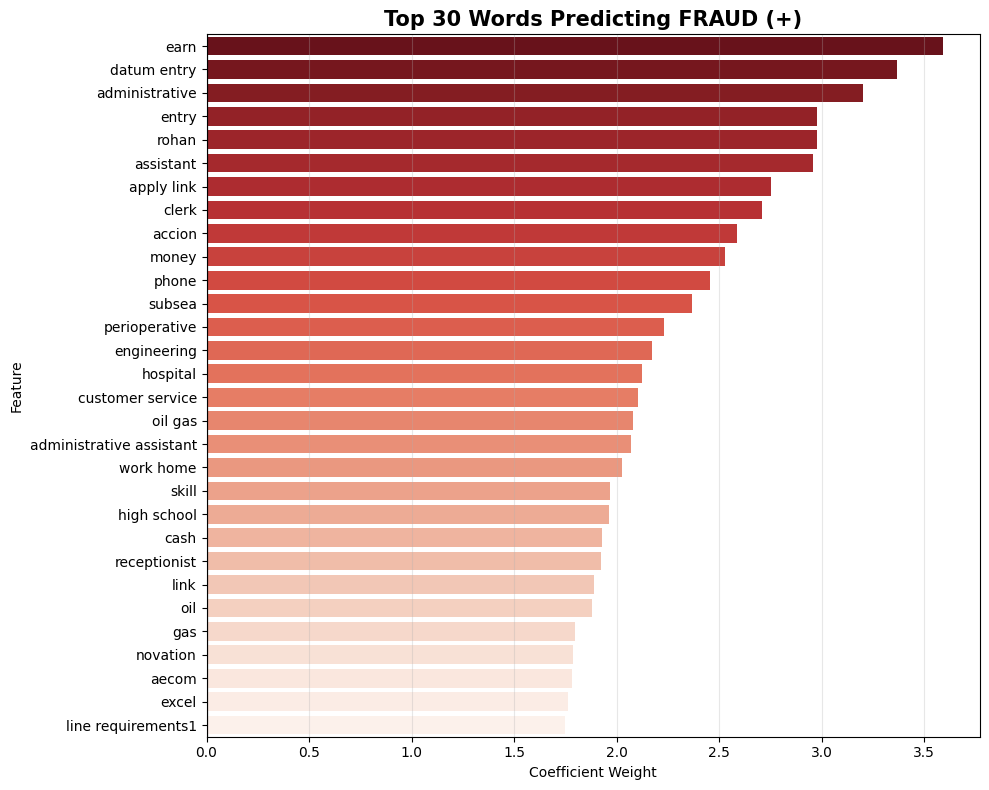

/var/folders/qb/7v1154wn6wd9cjd9z10hm0d00000gn/T/ipykernel_53970/1452477606.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_negative, y='feature', x='coef', palette='Blues_r')


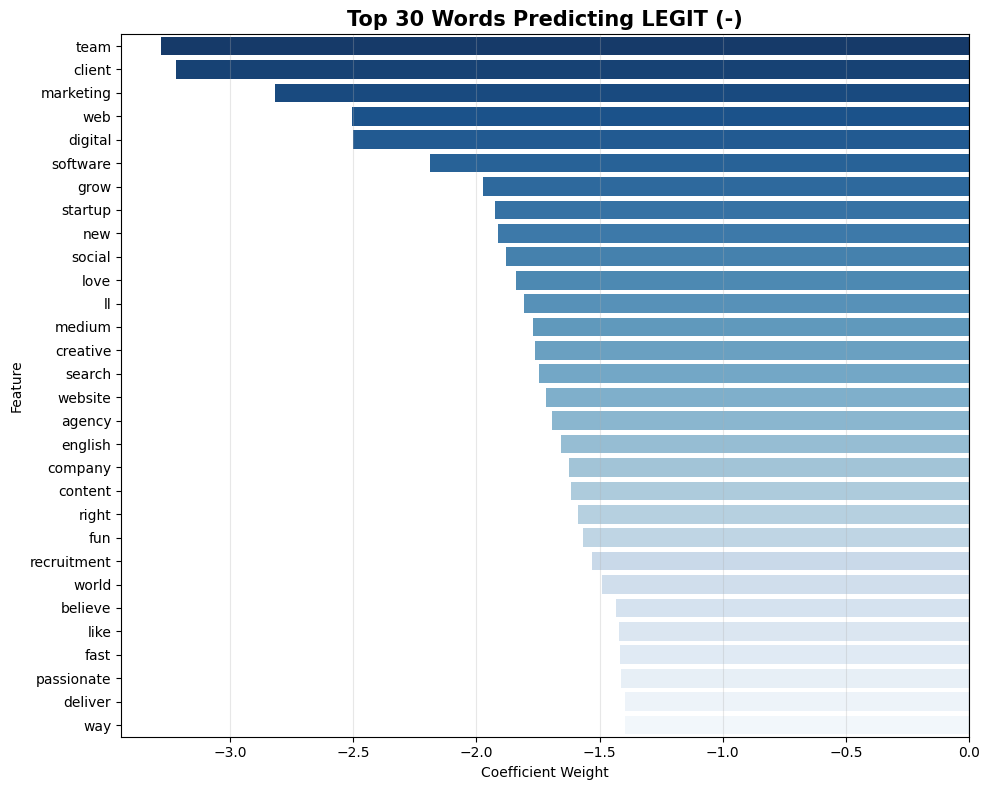

In [71]:
def plot_top_coefficients(pipeline, top_n=20):
    """
    Visualizes the top N positive (Fraud) and negative (Legit) coefficients 
    from a Logistic Regression pipeline.
    """
    # 1. Extract Vectorizer and Classifier from the Pipeline
    vectorizer = pipeline.named_steps['vectorizer']
    classifier = pipeline.named_steps['classifier']
    
    # 2. Get feature names and corresponding coefficients
    feature_names = vectorizer.get_feature_names_out()
    coefs = classifier.coef_[0]  # Shape is (1, n_features) for binary classification
    
    # 3. Create a DataFrame for easy sorting
    df_feats = pd.DataFrame({'feature': feature_names, 'coef': coefs})
    
    # 4. Extract Top Positive (Fraud indicators) and Top Negative (Legit indicators)
    top_positive = df_feats.sort_values('coef', ascending=False).head(top_n)
    top_negative = df_feats.sort_values('coef', ascending=True).head(top_n)
    
    # --- Plot 1: Top Fraud Indicators (Positive Coefficients) ---
    plt.figure(figsize=(10, 8))
    sns.barplot(data=top_positive, y='feature', x='coef', palette='Reds_r')
    plt.title(f'Top {top_n} Words Predicting FRAUD (+)', fontsize=15, fontweight='bold')
    plt.xlabel('Coefficient Weight')
    plt.ylabel('Feature')
    plt.axvline(0, color='black', linewidth=0.8)
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show() # Display the first plot
    
    # --- Plot 2: Top Legit Indicators (Negative Coefficients) ---
    plt.figure(figsize=(10, 8))
    sns.barplot(data=top_negative, y='feature', x='coef', palette='Blues_r')
    plt.title(f'Top {top_n} Words Predicting LEGIT (-)', fontsize=15, fontweight='bold')
    plt.xlabel('Coefficient Weight')
    plt.ylabel('Feature')
    plt.axvline(0, color='black', linewidth=0.8)
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show() # Display the second plot
    
    return top_positive, top_negative

# === Usage ===
top_fraud, top_legit = plot_top_coefficients(lr_tf_model, top_n=30)

### 2. False Positives


In [73]:
# lr_tf.head()

In [74]:
# select lr_tf true label = 1 and pred label = 0
lr_fn = lr_tf[(lr_tf['true_label'] == 1) & (lr_tf['predicted_label'] == 0)]
# select lr_tf true label = 0 and pred label = 1
lr_fp = lr_tf[(lr_tf['true_label'] == 0) & (lr_tf['predicted_label'] == 1)]

In [ ]:
worst_fps = lr_fp.sort_values("fraud_probability", ascending=False).head(5)
for i, row in worst_fps.iterrows():
    print(f"\n Index{i} (Prob: {row['fraud_probability']:.4f})")
    print(f"Text : {row['text'][:300]}...")


 Index314 (Prob: 0.6944)
Text : customer service work home 1 year customer servicecall center experience look flexibility scheduling availability work home currently hire customer service agent flexible scheduling work sale position outbound call call take inbound customer service callsvisit website click start complete job applic...

 Index1913 (Prob: 0.6637)
Text : parttime administrativedata entry time administrative assistant data entry responsible report directly account manager professional phone communication phone fax email respond resolve customer service issue assist manager meeting transcribe note copy organize prepare document sample coordinate trave...

 Index1926 (Prob: 0.6159)
Text : administrative assistant hayescorp create fun stuff focus software development mobile platform constantly look talented people think outside box logically creatively define coder marketer number cruncher resource excel good not position like think take send resume email_eaa37b5bf6cd5f435db5

In [75]:
suspicious_keywords = top_fraud['feature'].tolist()

def highlight_suspects(text, keywords):
    found = []
    text_lower = str(text).lower()
    for word in keywords:
        if word in text_lower:
            found.append(word)
    return found
for i, row in worst_fps.iterrows():
    hits = highlight_suspects(row['text'], suspicious_keywords)
    print(f"Index {i}: hits{hits}")

Index 314: hits['phone', 'customer service', 'work home', 'high school']
Index 1913: hits['administrative', 'entry', 'assistant', 'phone', 'customer service', 'administrative assistant', 'skill', 'excel']
Index 1926: hits['earn', 'administrative', 'entry', 'assistant', 'phone', 'administrative assistant', 'skill', 'receptionist', 'excel']
Index 2465: hits['earn', 'datum entry', 'administrative', 'entry', 'phone', 'customer service', 'skill', 'high school', 'receptionist', 'excel']
Index 724: hits['assistant', 'hospital']


### 3. False Negatives

In [ ]:
worst_fns = lr_fn.sort_values("fraud_probability", ascending=False).head(5)
for i, row in worst_fns.iterrows():
    print(f"\n Index {i} (Prob: {row['fraud_probability']:.4f})")
    print(f"Text: {row['text'][:]}...")


 Index 1204 (Prob: 0.5492)
Text: production manager heavy duty diesel 2022 2022job title production manager heavy duty dieselrole engineering relatedrelocation available yesindustry manufacturinglocation tennesseetown city morristownjob type permanent fulltimejob descriptionthe production manager responsible specify section department heavy duty piston operation business unit specify section typically comprise production cost center machine surface treatment process andor inspectionassembly process primary responsibility diesel production manager1 production operation machining product surface treatment andor inspectionassembly processesthe manager specific department business unit responsibility performance include product quality operational efficiency staffing salary hourly position production scheduling capacity utilization control cost labor operating expense maintenancekey measure success business unit establish zero base budgeting process complete annually key measure review re

In [ ]:
suspicious_keywords = top_legit['feature'].tolist()

def highlight_suspects(text, keywords):
    found = []
    text_lower = str(text).lower()
    for word in keywords:
        if word in text_lower:
            found.append(word)
    return found
for i, row in worst_fps.iterrows():
    hits = highlight_suspects(row['text'], suspicious_keywords)
    print(f"Index {i}: hits{hits}")

Index 314: hits['web', 'digital', 'software', 'll', 'website']
Index 1913: hits['team', 'social', 'll', 'medium', 'search', 'company']
Index 1926: hits['team', 'software', 'll', 'creative', 'english', 'fun', 'like']
Index 2465: hits['client', 'software', 'll', 'fun']
Index 724: hits['ll']


## Analyzing model errors to identify patterns and areas for improvement

In [ ]:
def has_pattern(s, pat):
    return int(bool(re.search(pat, s.lower())))

lr_fn["has_apply"] = lr_fn["text"].apply(lambda s: has_pattern(s, r"\bapply\b|\bresume\b"))
lr_fn["has_url"]   = lr_fn["text"].apply(lambda s: has_pattern(s, r"http|www|#url_"))
lr_fn["length"]    = lr_fn["text"].str.len()

lr_fn[["fraud_probability","has_apply","has_url","length"]].describe()

/var/folders/qb/7v1154wn6wd9cjd9z10hm0d00000gn/T/ipykernel_53970/3784730626.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_fn["has_apply"] = lr_fn["text"].apply(lambda s: has_pattern(s, r"\bapply\b|\bresume\b"))
/var/folders/qb/7v1154wn6wd9cjd9z10hm0d00000gn/T/ipykernel_53970/3784730626.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_fn["has_url"]   = lr_fn["text"].apply(lambda s: has_pattern(s, r"http|www|#url_"))
/var/folders/qb/7v1154wn6wd9cjd9z10hm0d00000gn/T/ipykernel_53970/3784730626.py

,fraud_probability,has_apply,has_url,length
count,19.000000,19.000000,19.0,19.000000
mean,0.335461,0.368421,0.0,1457.526316
std,0.159566,0.495595,0.0,1381.956760
min,0.083593,0.000000,0.0,50.000000
25%,0.200932,0.000000,0.0,433.000000
50%,0.386633,0.000000,0.0,1180.000000
75%,0.474188,1.000000,0.0,1895.000000
max,0.549221,1.000000,0.0,5296.000000


### False Negatives Analysis
False negatives tend to be long and detailed postings (median length ≈ 1.9k chars), which can dilute sparse lexical fraud cues in TF-IDF based models.
- Adding length-based features or using models that can capture long-range dependencies may help identify these cases.   

- Insight 1: The "Future Tense" Bias (The 'll' Phenomenon)

    Our analysis revealed that the contraction 'll (short for "will") is a strong negative predictor (indicating legitimacy) in the model. Legitimate job postings frequently use the future tense to describe career prospects and commitments (e.g., "You'll learn...", "We'll support..."). However, this creates a vulnerability: sophisticated scammers who adopt a conversational, promise-heavy tone can exploit this bias. By mimicking this "future-oriented" language, they can lower the model's suspicion score, leading to false negatives.

- Insight 2: Vulnerability to "Copy-Paste" Attacks

    A significant portion of False Negatives (e.g., Index 220, 1204) are the result of "high-fidelity mimicry." In these cases, scammers copy professional job descriptions verbatim from reputable companies, which contain dense industry terminology and legitimate keywords. Since TF-IDF relies heavily on lexical frequency, the model cannot distinguish between a genuine posting and a stolen one based on text content alone. This highlights the limitations of purely content-based detection and suggests that future iterations must incorporate non-textual features—such as verifying email domains or analyzing publisher IP history—to effectively flag these "clone" scams.                


## Part 3: Non-Linear Models (SVM)

In [ ]:
load_path = "/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/svm_best_model.pkl"
svm_cal = joblib.load(load_path)

### "The Hardest Cases"


In [83]:
# === 1. Identify Common False Negatives (Missed by both models) ===
# We are looking for cases where:
# - True Label is 1 (Fraud)
# - LR Predicted 0 (Legit)
# - SVM Predicted 0 (Legit)
common_fn_mask = (
    (lr_tf['true_label'] == 1) & 
    (lr_tf['predicted_label'] == 0) & 
    (svm['predicted_label'] == 0) 
)

common_fns = lr_tf[common_fn_mask]
print(f"Number of 'Hardest' Fraud cases missed by BOTH models: {len(common_fns)}")

# === 2. Sort by LR Probability ===
# Lower probability means the model was more confident it was Legit (i.e., a harder case)
hardest_cases = common_fns.sort_values("fraud_probability")

# === 3. Export to Text File ===
output_path = "hardest_fraud_cases.txt"

with open(output_path, "w", encoding="utf-8") as f:
    f.write(f"=== THE HARDEST CASES ({len(common_fns)} Total) ===\n")
    f.write("These are FRAUD samples that both Logistic Regression and SVM missed.\n")
    f.write("Ordered by LR predicted probability (Lowest = Model was most confident it's Legit).\n\n")

    for i, row in hardest_cases.iterrows():
        f.write(f"\n{'='*50}\n")
        f.write(f"[Index {i}] LR Prob: {row['fraud_probability']:.4f}\n")
        f.write(f"{'-'*20}\n")
        f.write(f"{row['text']}\n") 
        f.write(f"{'*'*50}\n")

print(f"✅ Successfully exported! Please check the file: {output_path}")

Number of 'Hardest' Fraud cases missed by BOTH models: 14
✅ Successfully exported! Please check the file: hardest_fraud_cases.txt


## Part 4: Model Pros & Cons Summary ?